In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!git clone https://github.com/LiyuanLucasLiu/RAdam.git

Cloning into 'RAdam'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 306 (delta 11), reused 16 (delta 3), pack-reused 274
Receiving objects: 100% (306/306), 949.66 KiB | 2.11 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [0]:
!unzip ./drive/My\ Drive/cifar.zip

In [0]:
import torch
import torchvision

In [0]:
import glob
import os

In [0]:
from RAdam.radam import RAdam

In [8]:
train_imgs = glob.glob('./cifar/train/*.png')
test_imgs = glob.glob('./cifar/test/*.png')
classes = []
with open('./cifar/labels.txt','r') as f:
  classes = f.readlines()
class_to_idx_dict = {class_.replace("\n",""):idx for idx, class_ in enumerate(classes)}
class_to_idx_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [0]:
transform = {
    'train':torchvision.transforms.Compose([
                                            torchvision.transforms.RandomResizedCrop(32),
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [0]:
from PIL import Image

In [0]:
class CIFAR10Dataset(torch.utils.data.Dataset):
  def __init__(self, img_path, transform=None, mode='train',class_to_idx_dict=class_to_idx_dict):
    super(CIFAR10Dataset, self).__init__()
    self.img_path = img_path
    self.transform = transform
    self.mode = mode
    self.class_to_idx_dict = class_to_idx_dict

  def __getitem__(self, idx):
    img_p = self.img_path[idx]
    img = Image.open(img_p)
    label = img_p.split('/')[-1].split('_')[-1].replace('.png','')
    label_idx = self.class_to_idx_dict[label]

    if self.transform:
      img = self.transform[self.mode](img)

    return img, label_idx

  def __len__(self):
    return len(self.img_path)

In [0]:
train_ds = CIFAR10Dataset(train_imgs, transform=transform,mode='train',class_to_idx_dict=class_to_idx_dict)
test_ds = CIFAR10Dataset(test_imgs, transform=transform, mode='test',class_to_idx_dict=class_to_idx_dict)

In [0]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)
dl_dict = {'train':train_dl,'test':test_dl}

In [0]:
num_epoch=200

In [0]:
hist = {"train_loss":[],"train_acc":[], "test_loss":[],"test_acc":[]}

# net = EfficientNet.from_pretrained('efficientnet-b1')
# net._fc = torch.nn.Linear(in_features=net._bn1.num_features,out_features=num_classes)

# net = torchvision.models.resnet50(pretrained=False)
# net.fc = torch.nn.Linear(2048,10)

net = torchvision.models.resnet18()
net.fc = torch.nn.Linear(512, 10)
model_name = net.__class__.__name__
criterion = torch.nn.CrossEntropyLoss()
optimizer = RAdam(net.parameters(),lr=1e-2,betas=(0.9,0.999))
# optimizer = torch.optim.Adam(net.parameters(),lr=1e-2, betas=(0.9,0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, num_epoch/4)

device = "cuda:0" if torch.cuda.is_available else "cpu"
net.to(device)
torch.backends.cudnn.benchmark=True

In [46]:
import time
print("START")
print(type(optimizer))
for epoch in range(num_epoch):
    cur_lr = scheduler.get_lr()[0]
    since = time.time()
    net.train()
    epoch_loss = 0.
    epoch_correct = 0.
    epoch_imgs = 0
    for batch in train_dl:
        #print(i+1)
        imgs,labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        epoch_imgs += len(labels)

        optimizer.zero_grad()
        output = net(imgs)
        loss = criterion(output, labels)        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()*imgs.size(0)
        epoch_correct += sum(output.argmax(1)==labels)

    t_l = epoch_loss/epoch_imgs
    t_a = float(epoch_correct/epoch_imgs)
    hist['train_loss'].append(t_l)
    hist['train_acc'].append(t_a)
    print("Epoch {}: Loss: {:.4f} Acc: {:.4f} Time: {:.2f} lr: {:.6f}".format(epoch+1,t_l,t_a, time.time()-since, cur_lr)) 

    net.eval()
    val_loss = 0.
    val_correct = 0.
    val_imgs = 0
    with torch.no_grad():
      for batch in test_dl:
          imgs,labels = batch
          imgs = imgs.to(device)
          labels = labels.to(device)
          val_imgs += len(labels)
          output = net(imgs)
          loss = criterion(output, labels)        
          
          val_loss += loss.item()*imgs.size(0)
          val_correct += sum(output.argmax(1)==labels) 

    l = val_loss/val_imgs
    a = float(val_correct/val_imgs)
    hist['test_loss'].append(l)
    hist['test_acc'].append(a)
    print("Val: Loss: {:.4f} Acc: {:.4f}".format(l,a)) 

    scheduler.step()

START
<class 'RAdam.radam.RAdam'>
Epoch 1: Loss: 1.8566 Acc: 0.3211 Time: 34.32 lr: 0.010000
Val: Loss: 1.5757 Acc: 0.4341
Epoch 2: Loss: 1.6351 Acc: 0.4117 Time: 34.33 lr: 0.010000
Val: Loss: 1.3606 Acc: 0.5103
Epoch 3: Loss: 1.5002 Acc: 0.4648 Time: 35.12 lr: 0.010000
Val: Loss: 1.2278 Acc: 0.5627
Epoch 4: Loss: 1.4010 Acc: 0.4983 Time: 34.48 lr: 0.010000
Val: Loss: 1.2986 Acc: 0.5555
Epoch 5: Loss: 1.3265 Acc: 0.5312 Time: 33.69 lr: 0.010000
Val: Loss: 1.0222 Acc: 0.6416
Epoch 6: Loss: 1.2504 Acc: 0.5582 Time: 33.48 lr: 0.010000
Val: Loss: 1.0849 Acc: 0.6319
Epoch 7: Loss: 1.2072 Acc: 0.5751 Time: 33.67 lr: 0.010000
Val: Loss: 0.9902 Acc: 0.6615
Epoch 8: Loss: 1.1533 Acc: 0.5937 Time: 33.26 lr: 0.010000
Val: Loss: 0.9260 Acc: 0.6864
Epoch 9: Loss: 1.1144 Acc: 0.6105 Time: 34.23 lr: 0.010000
Val: Loss: 0.8830 Acc: 0.6972
Epoch 10: Loss: 1.0882 Acc: 0.6204 Time: 33.55 lr: 0.010000
Val: Loss: 0.8929 Acc: 0.7040
Epoch 11: Loss: 1.0606 Acc: 0.6279 Time: 34.21 lr: 0.010000
Val: Loss: 0.88

In [0]:
radam_hist = hist

In [0]:
hist = {"train_loss":[],"train_acc":[], "test_loss":[],"test_acc":[]}

# net = EfficientNet.from_pretrained('efficientnet-b1')
# net._fc = torch.nn.Linear(in_features=net._bn1.num_features,out_features=num_classes)

# net = torchvision.models.resnet50(pretrained=False)
# net.fc = torch.nn.Linear(2048,10)

net = torchvision.models.resnet18()
net.fc = torch.nn.Linear(512, 10)
model_name = net.__class__.__name__
criterion = torch.nn.CrossEntropyLoss()
# optimizer = RAdam(net.parameters(),lr=1e-2,betas=(0.9,0.999))
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2, betas=(0.9,0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, num_epoch/4)

device = "cuda:0" if torch.cuda.is_available else "cpu"
net.to(device)
torch.backends.cudnn.benchmark=True

In [21]:
import time
print("START")
print(type(optimizer))
for epoch in range(num_epoch):
    cur_lr = scheduler.get_lr()[0]
    since = time.time()
    net.train()
    epoch_loss = 0.
    epoch_correct = 0.
    epoch_imgs = 0
    for batch in train_dl:
        #print(i+1)
        imgs,labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        epoch_imgs += len(labels)

        optimizer.zero_grad()
        output = net(imgs)
        loss = criterion(output, labels)        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()*imgs.size(0)
        epoch_correct += sum(output.argmax(1)==labels)

    t_l = epoch_loss/epoch_imgs
    t_a = float(epoch_correct/epoch_imgs)
    hist['train_loss'].append(t_l)
    hist['train_acc'].append(t_a)
    print("Epoch {}: Loss: {:.4f} Acc: {:.4f} Time: {:.2f} lr: {:.7f}".format(epoch+1,t_l,t_a, time.time()-since, cur_lr)) 

    net.eval()
    val_loss = 0.
    val_correct = 0.
    val_imgs = 0
    with torch.no_grad():
      for batch in test_dl:
          imgs,labels = batch
          imgs = imgs.to(device)
          labels = labels.to(device)
          val_imgs += len(labels)
          output = net(imgs)
          loss = criterion(output, labels)        
          
          val_loss += loss.item()*imgs.size(0)
          val_correct += sum(output.argmax(1)==labels) 

    l = val_loss/val_imgs
    a = float(val_correct/val_imgs)
    hist['test_loss'].append(l)
    hist['test_acc'].append(a)
    print("Val: Loss: {:.4f} Acc: {:.4f}".format(l,a)) 

    scheduler.step()

START
<class 'torch.optim.adam.Adam'>
Epoch 1: Loss: 2.0648 Acc: 0.2668 Time: 36.36 lr: 0.0100000
Val: Loss: 1.6764 Acc: 0.3846
Epoch 2: Loss: 1.7305 Acc: 0.3645 Time: 34.33 lr: 0.0100000
Val: Loss: 1.6203 Acc: 0.4061
Epoch 3: Loss: 1.6009 Acc: 0.4195 Time: 34.36 lr: 0.0100000
Val: Loss: 1.4299 Acc: 0.4824
Epoch 4: Loss: 1.4773 Acc: 0.4649 Time: 34.36 lr: 0.0100000
Val: Loss: 1.2570 Acc: 0.5573
Epoch 5: Loss: 1.3821 Acc: 0.5051 Time: 34.18 lr: 0.0100000
Val: Loss: 1.2098 Acc: 0.5867
Epoch 6: Loss: 1.2998 Acc: 0.5382 Time: 34.34 lr: 0.0100000
Val: Loss: 1.0533 Acc: 0.6311
Epoch 7: Loss: 1.2592 Acc: 0.5517 Time: 34.30 lr: 0.0100000
Val: Loss: 1.0285 Acc: 0.6370
Epoch 8: Loss: 1.1973 Acc: 0.5750 Time: 34.20 lr: 0.0100000
Val: Loss: 1.0639 Acc: 0.6484
Epoch 9: Loss: 1.1550 Acc: 0.5917 Time: 34.66 lr: 0.0100000
Val: Loss: 0.9860 Acc: 0.6674
Epoch 10: Loss: 1.1150 Acc: 0.6049 Time: 34.25 lr: 0.0100000
Val: Loss: 0.9153 Acc: 0.6806
Epoch 11: Loss: 1.0907 Acc: 0.6193 Time: 34.21 lr: 0.0100000


In [0]:
adam_hist = hist

## ResNet-18(large lr w/o pre-trained)

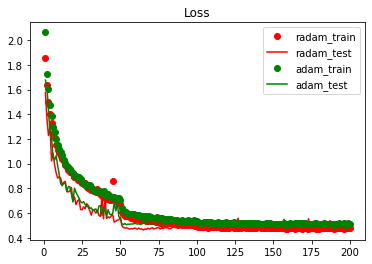

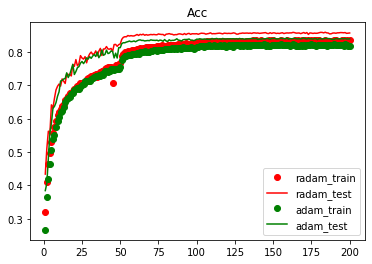

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs =range(1,num_epoch+1)

plt.title('Loss')
plt.plot(epochs, radam_hist['loss'],'ro',label='radam_train')
plt.plot(epochs, radam_hist['val_loss'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_loss'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_loss'],'g',label='adam_test')
# plt.ylim((0.0,0.1))
plt.legend()
plt.show()

plt.figure()
plt.title('Acc')
plt.plot(epochs, radam_hist['acc'],'ro',label='radam_train')
plt.plot(epochs, radam_hist['val_acc'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_acc'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_acc'],'g',label='adam_test')
# plt.ylim((0.96,1.0))
plt.legend()
plt.show()

## ResNet-18(small batch w/o pre-trained)

In [0]:
with open('./radam_small_hist.txt','w') as fw:
  fw.write(str(radam_hist))

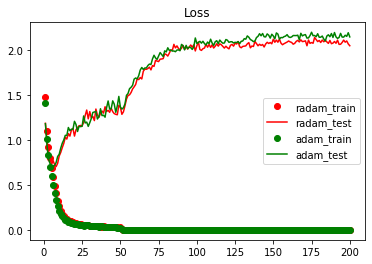

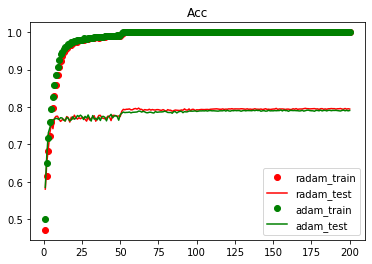

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs =range(1,num_epoch+1)

plt.title('Loss')
plt.plot(epochs, radam_hist['train_loss'],'ro',label='radam_train')
plt.plot(epochs, radam_hist['test_loss'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_loss'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_loss'],'g',label='adam_test')
# plt.ylim((0.0,0.1))
plt.legend()
plt.show()

plt.figure()
plt.title('Acc')
plt.plot(epochs, radam_hist['train_acc'],'ro',label='radam_train')
plt.plot(epochs, radam_hist['test_acc'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_acc'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_acc'],'g',label='adam_test')
# plt.ylim((0.96,1.0))
plt.legend()
plt.show()

## ResNet-50 (w/o pre-trained)

In [0]:
with open('./adam_hist.txt','w') as fw:
  fw.write(str(adam_hist))

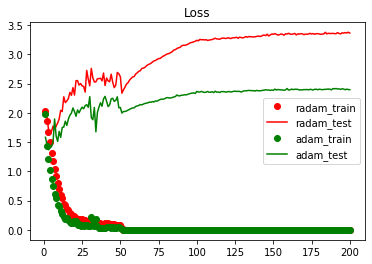

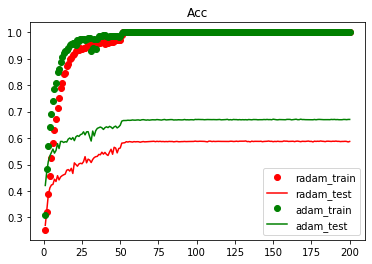

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs =range(1,epoch_num+1)

plt.title('Loss')
plt.plot(epochs, radam_hist['train_loss'],'ro',label='radam_train')
plt.plot(epochs, radam_hist['test_loss'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_loss'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_loss'],'g',label='adam_test')
# plt.ylim((0.0,0.1))
plt.legend()
plt.show()

plt.figure()
plt.title('Acc')
plt.plot(epochs, radam_hist['train_acc'],'ro',label='radam_train')
plt.plot(epochs, radam_hist['test_acc'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_acc'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_acc'],'g',label='adam_test')
# plt.ylim((0.96,1.0))
plt.legend()
plt.show()

## Efficientnet (w/ pre-trained)

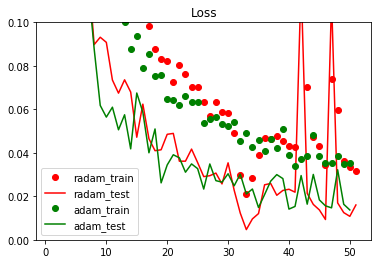

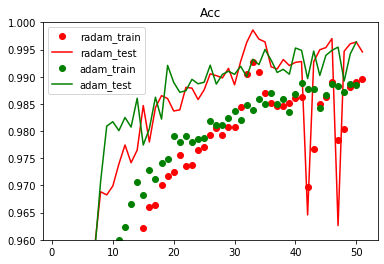

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs =range(1,epoch_num+1)

plt.title('Loss')
plt.plot(epochs, radam_hist['train_loss'],'ro',label='radam_train')
plt.plot(epochs, radam_hist['test_loss'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_loss'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_loss'],'g',label='adam_test')
plt.ylim((0.0,0.1))
plt.legend()

plt.figure()
plt.title('Acc')
plt.plot(epochs, radam_hist['train_acc'],'ro',label='radam_train')
plt.plot(epochs, radam_hist['test_acc'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_acc'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_acc'],'g',label='adam_test')
plt.ylim((0.96,1.0))
plt.legend()

## Discussion
Model: EfficientNet
**RAdam seems to be beaten by Adam** (Can't see the improvement...)

Possible Causes:  

1. * Pretrained Model? -> RAdam assumes initial weights as $w_0 \sim \mathcal{N}(0,I)$
  *  EfficientNet(99 %, both) is too good at CIFAR-10 by default. -> Try another model

2. Too big batch size(=1024)? <- RAdam assumes Adam might make wrong big jump in the early steps because there is few data. Big batch contradicts this situation.

Experiments:

1. Train a model(ResNet-50) with $w_0 \sim \mathcal{N}(0,I)$
2. **Try smaller batch size(=32)**. (ResNet-18)


Results:

1. Too bad. RAdam(55 %) is worse than Adam(65 %), again.
2. **RAdam(79.5 %) is better than Adam(79.1 %)**
